# Text classification using AG News dataset - csatrio

### Parameter setting

In [2]:
import os
import torch

model_name = 'text_classification'
output_directory = f'{model_name}_assets'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
o = lambda x : os.path.join(os.getcwd(), output_directory, x)
visualization_name = o(f'{model_name}_torchviz')
visualization_format = 'png'
output_model_name = o(f'{model_name}.pt')

def select_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():    
        return torch.device('mps')
    else:
        return torch.device('cpu')

# device = select_device()
device = torch.device('cpu')
device

device(type='cpu')

### Create model class that inherits nn.module

In [3]:
import torch.nn as nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets=0):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Prepare data & text processing pipelines

In [4]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS

# Data processing pipeline
tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Text Processing Pipeline
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

### Generate data batch and iterator

In [5]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        # data type during the process must be the same with the one used for visualizing the model
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_iter = AG_NEWS(split="train")
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)


In [6]:
torch.manual_seed(32) # set the random seed for reproducibility
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model.parameters # print the model parameters

<bound method Module.parameters of TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)>

### Function to train model and evaluate results

In [7]:
import time

learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        # losses.append(loss.detach().numpy()) # store the loss, detach() removes the loss from the computational graph
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

### Split the dataset and run the model

In [8]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 2  # epoch
LR = 0.1  # learning rate
BATCH_SIZE = 64  # batch size for training

losses = []
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    losses.append(min(1, 1 - accu_val))
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.253
| epoch   1 |  1000/ 1782 batches | accuracy    0.254
| epoch   1 |  1500/ 1782 batches | accuracy    0.252
-----------------------------------------------------------
| end of epoch   1 | time: 10.51s | valid accuracy    0.254 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.258
| epoch   2 |  1000/ 1782 batches | accuracy    0.256
| epoch   2 |  1500/ 1782 batches | accuracy    0.253
-----------------------------------------------------------
| end of epoch   2 | time: 10.02s | valid accuracy    0.258 
-----------------------------------------------------------


### Evaluate Model With Test Dataset

In [9]:
print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.254


### Test on a random news

In [10]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}


def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a World news


Text(0.5, 0, 'epoch')

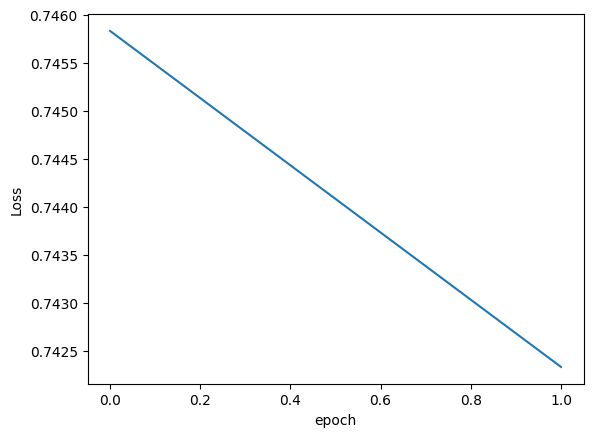

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Graph our losses
plt.plot(range(EPOCHS) , losses) # plot the loss values with correct dimensions
plt.ylabel('Loss') # label the y-axis
plt.xlabel('epoch') # label the x-axis

In [12]:
# Save the model
torch.save(model.state_dict(), output_model_name)

### Visualize the neural network

In [15]:
from torchviz import make_dot

# create some sample input data
x = split_valid_[0]

# generate predictions for the sample data
# data type during the process must be the same with the one used for visualizing the model
# eg. if it's torch.int64 in the model, it must be torch.int64 here
# otherwise the matrix multiplication will fail, and the visualization will not be generated
processed_text = torch.tensor(text_pipeline(x[1]), dtype=torch.int64).unsqueeze(0)

y = model(processed_text, None)

# generate a model architecture visualization
z = make_dot(y.mean(),
         params=dict(model.named_parameters()),
         show_attrs=True,
         show_saved=True).render(visualization_name, format=visualization_format)

In [16]:
from IPython.display import Markdown as md
md_text = f'![title]({model_name}_assets/{model_name}_torchviz.png)'
md(md_text)

![title](text_classification_assets/text_classification_torchviz.png)